In [48]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [49]:
import torch
from torch import nn

In [50]:
#from fastai.conv_learner import *



#from fastai.dataset import *
from fastai.transforms import RandomFlip,RandomRotate,RandomLighting,TfmType,tfms_from_model,CropType
from pathlib import Path
import collections
import numpy as np
import json
import pandas as pd
from PIL import ImageDraw, ImageFont,Image
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

#torch.cuda.set_device(0)

In [51]:
import os

In [52]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu');device

device(type='cpu')

In [53]:
PATH = Path('data/')

# Read and Process Data


In [7]:
train_json = json.load((PATH/'PASCAL_VOC/pascal_train2007.json').open())
val_json = json.load((PATH/'PASCAL_VOC/pascal_val2007.json').open())

In [8]:
IMAGES,ANNOTATIONs,CATEGORIES = ['images','annotations','categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

# id_to_cat = {o[ID]:o['name'] for o in train_json[CATEGORIES]}
# id_to_file = {o[ID]:o[FILE_NAME] for o in train_json[IMAGES]} 
# train_ids = [o[ID] for o in train_json[IMAGES]]

JPEG = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEG


In [9]:
trn_images_pd = pd.DataFrame(train_json[IMAGES])
trn_annotations_pd = pd.DataFrame(train_json[ANNOTATIONs])
trn_categories_pd = pd.DataFrame(train_json[CATEGORIES])

val_images_pd = pd.DataFrame(val_json[IMAGES])
val_annotations_pd = pd.DataFrame(val_json[ANNOTATIONs])
val_categories_pd = pd.DataFrame(val_json[CATEGORIES])

In [10]:
trn_images_pd.head()

,file_name,height,id,width
0,000012.jpg,333,12,500
1,000017.jpg,364,17,480
2,000023.jpg,500,23,334
3,000026.jpg,333,26,500
4,000032.jpg,281,32,500


In [11]:
trn_annotations_pd.head()

,area,bbox,category_id,id,ignore,image_id,iscrowd,segmentation
0,34104,"[155, 96, 196, 174]",7,1,0,12,0,"[[155, 96, 155, 270, 351, 270, 351, 96]]"
1,13110,"[184, 61, 95, 138]",15,2,0,17,0,"[[184, 61, 184, 199, 279, 199, 279, 61]]"
2,81326,"[89, 77, 314, 259]",13,3,0,17,0,"[[89, 77, 89, 336, 403, 336, 403, 77]]"
3,64227,"[8, 229, 237, 271]",2,4,0,23,0,"[[8, 229, 8, 500, 245, 500, 245, 229]]"
4,29505,"[229, 219, 105, 281]",2,5,0,23,0,"[[229, 219, 229, 500, 334, 500, 334, 219]]"


In [12]:
trn_categories_pd.head()

,id,name,supercategory
0,1,aeroplane,none
1,2,bicycle,none
2,3,bird,none
3,4,boat,none
4,5,bottle,none


In [13]:
trn_data = trn_annotations_pd.merge(trn_categories_pd,how='left',left_on = 'category_id',right_on='id').merge(trn_images_pd,how='left',left_on='image_id',right_on='id')
val_data = val_annotations_pd.merge(val_categories_pd,how='left',left_on = 'category_id',right_on='id').merge(val_images_pd,how='left',left_on='image_id',right_on='id')

In [14]:
trn_data.head()

,area,bbox,category_id,id_x,ignore,image_id,iscrowd,segmentation,id_y,name,supercategory,file_name,height,id,width
0,34104,"[155, 96, 196, 174]",7,1,0,12,0,"[[155, 96, 155, 270, 351, 270, 351, 96]]",7,car,none,000012.jpg,333,12,500
1,13110,"[184, 61, 95, 138]",15,2,0,17,0,"[[184, 61, 184, 199, 279, 199, 279, 61]]",15,person,none,000017.jpg,364,17,480
2,81326,"[89, 77, 314, 259]",13,3,0,17,0,"[[89, 77, 89, 336, 403, 336, 403, 77]]",13,horse,none,000017.jpg,364,17,480
3,64227,"[8, 229, 237, 271]",2,4,0,23,0,"[[8, 229, 8, 500, 245, 500, 245, 229]]",2,bicycle,none,000023.jpg,500,23,334
4,29505,"[229, 219, 105, 281]",2,5,0,23,0,"[[229, 219, 229, 500, 334, 500, 334, 219]]",2,bicycle,none,000023.jpg,500,23,334


In [21]:
val_data.head()

,area,bbox,category_id,id_x,ignore,image_id,iscrowd,segmentation,id_y,name,supercategory,file_name,height,id,width
0,7998,"[262, 210, 62, 129]",9,1,0,5,0,"[[262, 210, 262, 339, 324, 339, 324, 210]]",9,chair,none,000005.jpg,375,5,500
1,9701,"[164, 263, 89, 109]",9,2,0,5,0,"[[164, 263, 164, 372, 253, 372, 253, 263]]",9,chair,none,000005.jpg,375,5,500
2,8253,"[4, 243, 63, 131]",9,3,1,5,0,"[[4, 243, 4, 374, 67, 374, 67, 243]]",9,chair,none,000005.jpg,375,5,500
3,5830,"[240, 193, 55, 106]",9,4,0,5,0,"[[240, 193, 240, 299, 295, 299, 295, 193]]",9,chair,none,000005.jpg,375,5,500
4,1260,"[276, 185, 36, 35]",9,5,1,5,0,"[[276, 185, 276, 220, 312, 220, 312, 185]]",9,chair,none,000005.jpg,375,5,500


In [22]:
trn_largest_bbox = trn_data.pivot_table(index='file_name',values='area',aggfunc=max).reset_index()
trn_largest_bbox = trn_largest_bbox.merge(trn_data[['area','bbox','image_id','file_name','name','category_id']],how='left')


val_largest_bbox = val_data.pivot_table(index='file_name',values='area',aggfunc=max).reset_index()
val_largest_bbox = val_largest_bbox.merge(val_data[['area','bbox','image_id','file_name','name','category_id']],how='left')

In [23]:
trn_largest_bbox.head()

,file_name,area,bbox,image_id,name,category_id
0,000012.jpg,34104,"[155, 96, 196, 174]",12,car,7
1,000017.jpg,81326,"[89, 77, 314, 259]",17,horse,13
2,000023.jpg,111101,"[2, 1, 241, 461]",23,person,15
3,000026.jpg,21824,"[89, 124, 248, 88]",26,car,7
4,000032.jpg,28832,"[103, 77, 272, 106]",32,aeroplane,1


In [24]:
def hw_bb(bb):return np.array([bb[1],bb[0],bb[3]+bb[1]-1,bb[2]+bb[0]-1])

def bb_hw(a):return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])


trn_largest_bbox['bbox_new'] = trn_largest_bbox['bbox'].apply(lambda x: hw_bb(x))
trn_largest_bbox.drop_duplicates(subset='file_name', inplace=True)

val_largest_bbox['bbox_new'] = val_largest_bbox['bbox'].apply(lambda x: hw_bb(x))
val_largest_bbox.drop_duplicates(subset='file_name', inplace=True)


In [25]:
print(len(trn_largest_bbox),len(val_largest_bbox))

2501 2510


In [26]:
trn_largest_bbox.head()

,file_name,area,bbox,image_id,name,category_id,bbox_new
0,000012.jpg,34104,"[155, 96, 196, 174]",12,car,7,"[96, 155, 269, 350]"
1,000017.jpg,81326,"[89, 77, 314, 259]",17,horse,13,"[77, 89, 335, 402]"
2,000023.jpg,111101,"[2, 1, 241, 461]",23,person,15,"[1, 2, 461, 242]"
3,000026.jpg,21824,"[89, 124, 248, 88]",26,car,7,"[124, 89, 211, 336]"
4,000032.jpg,28832,"[103, 77, 272, 106]",32,aeroplane,1,"[77, 103, 182, 374]"


In [27]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o,lw):
    o.set_path_effects([patheffects.Stroke(
    linewidth=lw,foreground='black'),patheffects.Normal()])
    
def draw_rect(ax,b):
    patch = ax.add_patch(patches.Rectangle(b[:2],*b[-2:],fill=False,edgecolor='white',lw=2))
    draw_outline(patch,4)
    
def draw_text(ax,xy,txt,sz=14):
    text = ax.text(*xy,txt,
                  verticalalignment='top',color='white',fontsize=sz,weight='bold')
    draw_outline(text,1)
    
def draw_im(im,ann):
    ax = show_img(im,figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax,b)
        draw_text(ax,b[:2],id_to_cat[c],sz=16)
        
def img_denorm(image):
    
    m = [0.485, 0.456, 0.406]
    s = [0.229, 0.224, 0.225]
    
    im = np.array(image)
    im = np.transpose(im,(1,2,0))
    np_m=np.array(m, dtype=np.float32)
    np_s=np.array(s, dtype=np.float32)
    
    return im*np_s+np_m

def plot_multiple_image(images,bboxes=None,classes=None,tru_classes=None):
    
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    
    for i,ax in enumerate(axes.flat):
        
        image = img_denorm(images[i])
        
        ax = show_img(image, ax=ax)
        txt_cord = [0,0]
        
        if bboxes is not None:
            bb = bb_hw(bboxes[i])
            txt_cord = bb[:2]
            draw_rect(ax, bb)
            
        if classes is not None: 
            txt = idx2labels[int(classes[i])]
            draw_text(ax, txt_cord, txt)
            
        if tru_classes is not None:
            
            txt = idx2labels[int(tru_classes[i])]
            txt_cord[0] = txt_cord[0]+100
            draw_text(ax,txt_cord, txt)
            
    plt.tight_layout()

        
# def draw_idx(im_a,i):
#     im_a = trn_anno[i]
#     im = Image.open(IMG_PATH/id_to_file[i])
#     im = np.array(im)
#     print(im.shape)
#     draw_im(im,im_a)
    
# draw_idx(17)
 

In [28]:
labels = trn_largest_bbox['name'].tolist()

all_labels = sorted(list(set(labels)))

label2idx = {v:k for k,v in enumerate(all_labels)} 
idx2labels = {k:v for k,v in enumerate(all_labels)}


In [29]:
trn_input = [os.path.join(JPEG,str(fn)+'') for fn in trn_largest_bbox['file_name'].tolist()]
trn_target = np.float32(trn_largest_bbox['bbox_new'].tolist())
trn_target_2 = np.float32([label2idx[label] for label in trn_largest_bbox['name'].tolist()])

val_input = [os.path.join(JPEG,str(fn)+'') for fn in val_largest_bbox['file_name'].tolist()]
val_target = np.float32(val_largest_bbox['bbox_new'].tolist())
val_target_2 = np.float32([label2idx[label] for label in val_largest_bbox['name'].tolist()])

trn_input[0],trn_target[0]

('VOCdevkit/VOC2007/JPEGImages/000012.jpg',
 array([ 96., 155., 269., 350.], dtype=float32))

In [30]:
sz=224
bs=64
epochs = 10

In [31]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(sz, crop_type=CropType.NO, aug_tfms=augs,tfm_y=tfm_y)


In [38]:
from aliai.dataloader import get_concat_data_loader

input_data = {'train':trn_input,'valid':val_input}

label = {'train':trn_target,'valid':val_target}

label2 = {'train':trn_target_2,'valid':val_target_2}

tfms_dict = {'train':tfms[0],'valid':tfms[1]}

train_dataloader, test_dataloader,aug_dataloader = get_concat_data_loader(input_data,label,label2,tfms_dict,PATH,bs)

<class 'torch.Tensor'> <class 'list'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([64, 3, 224, 224])


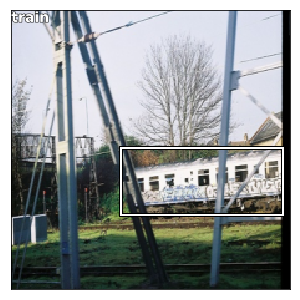

In [41]:
import numpy as np

ab,c = next(iter(aug_dataloader))
bb,txt = c

print(type(ab),type(c),type(bb),type(txt))
print(ab.shape)

idx = 7
ab_ = ab[idx]
bb_ = bb[idx]
txt_ = txt[idx]


m = [0.485, 0.456, 0.406]
s = [0.229, 0.224, 0.225]
  
im = np.array(ab_)
im = np.transpose(im,(1,2,0))

np_m=np.array(m, dtype=np.float32)
np_s=np.array(s, dtype=np.float32)

imp = im*np_s+np_m

label = idx2labels[int(txt_)]


ax = show_img(imp,figsize=(5,10))
draw_rect(ax,bb_hw(bb_))
draw_text(ax,(0,0),label)

In [42]:
from aliai.model import Model
#header = nn.Sequential(Flatten(),nn.Linear512,len(all_labels))
model = Model(4+len(all_labels),is_reg=True).to(device)

In [43]:
def detn_loss(input_, target):
    sigmoid = nn.Sigmoid()
    l1loss = nn.L1Loss()
    entropyloss = nn.CrossEntropyLoss()
    
    bb_t,c_t = target
    bb_t = bb_t.to(device)
    c_t  = Variable(c_t).type(torch.LongTensor).to(device)
    bb_i,c_i = input_[:, :4], input_[:, 4:]
    
    bb_i = sigmoid(bb_i)*224
   #bb_t  = sigmoid(bb_t.data)*224
    
    return l1loss(bb_i, bb_t) + entropyloss(c_i, c_t)


optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.001)

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i =nn.sigmoid(bb_i)*224
    return nn.L1Loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy_np(c_i, c_t)

In [44]:
from torch.autograd import Variable

In [46]:
def train(train_dataloader,modelz, detn_loss,optimizer,epochs=5):
    
    total_step = len(train_dataloader)
    
    for epoch in range(epochs):
        
        for i,(images,labels) in enumerate(train_dataloader):
            images = images.to(device)
           
        
            output = modelz(images)
            
            loss = detn_loss(output,labels)
            
            
            optimizer.zero_grad()
            loss.backward()
        
            optimizer.step()
        
            if (i+1) % 20 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, epochs, i+1, total_step, loss.item()))
#train(train_dataloader, model,detn_loss,optimizer,10)

In [31]:
torch.save(model,'data/best_single_object.pt')

In [54]:
model = torch.load('data/best_single_object.pt')

/home/ubuntu/anaconda3/envs/nlp_env/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'aliai.model.Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


RuntimeError: cuda runtime error (30) : unknown error at torch/csrc/cuda/Module.cpp:51

In [56]:
from scipy.special import expit
ss = nn.Sigmoid()

In [69]:
model.eval()
with torch.no_grad():
    images,targets = next(iter(test_dataloader))
    images = images.to(device)
    output = model(images)

bb_targets,txt_targets = targets
bb_labels,txt_labels = expit(output[:, :4])*224, output[:, 4:]

_,txt_labels = torch.max(txt_labels,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


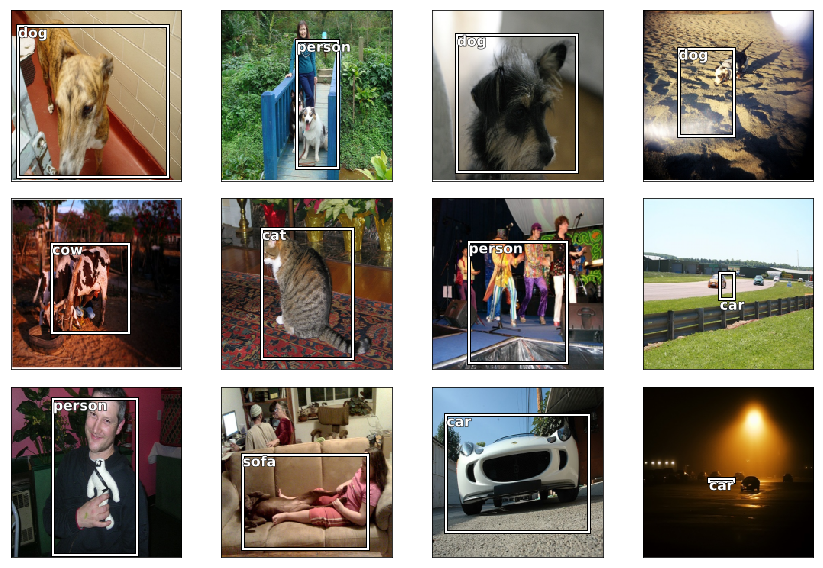

In [70]:
plot_multiple_image(images,bboxes=bb_labels,classes=txt_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


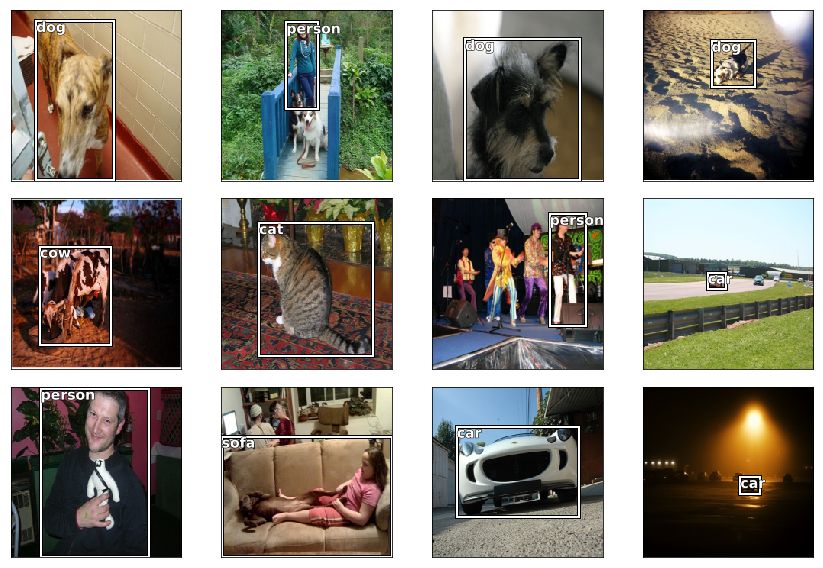

In [71]:
plot_multiple_image(images,bboxes=bb_targets,classes=txt_targets)